### Import thư viện

In [75]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import itertools
import os
import cv2

In [76]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [77]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

### Đọc dữ liệu

In [107]:
# đọc tên các lớp :  có 9 loại
DIR = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
# DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [108]:
data = []
path = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
# path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        data.append([img, folder])

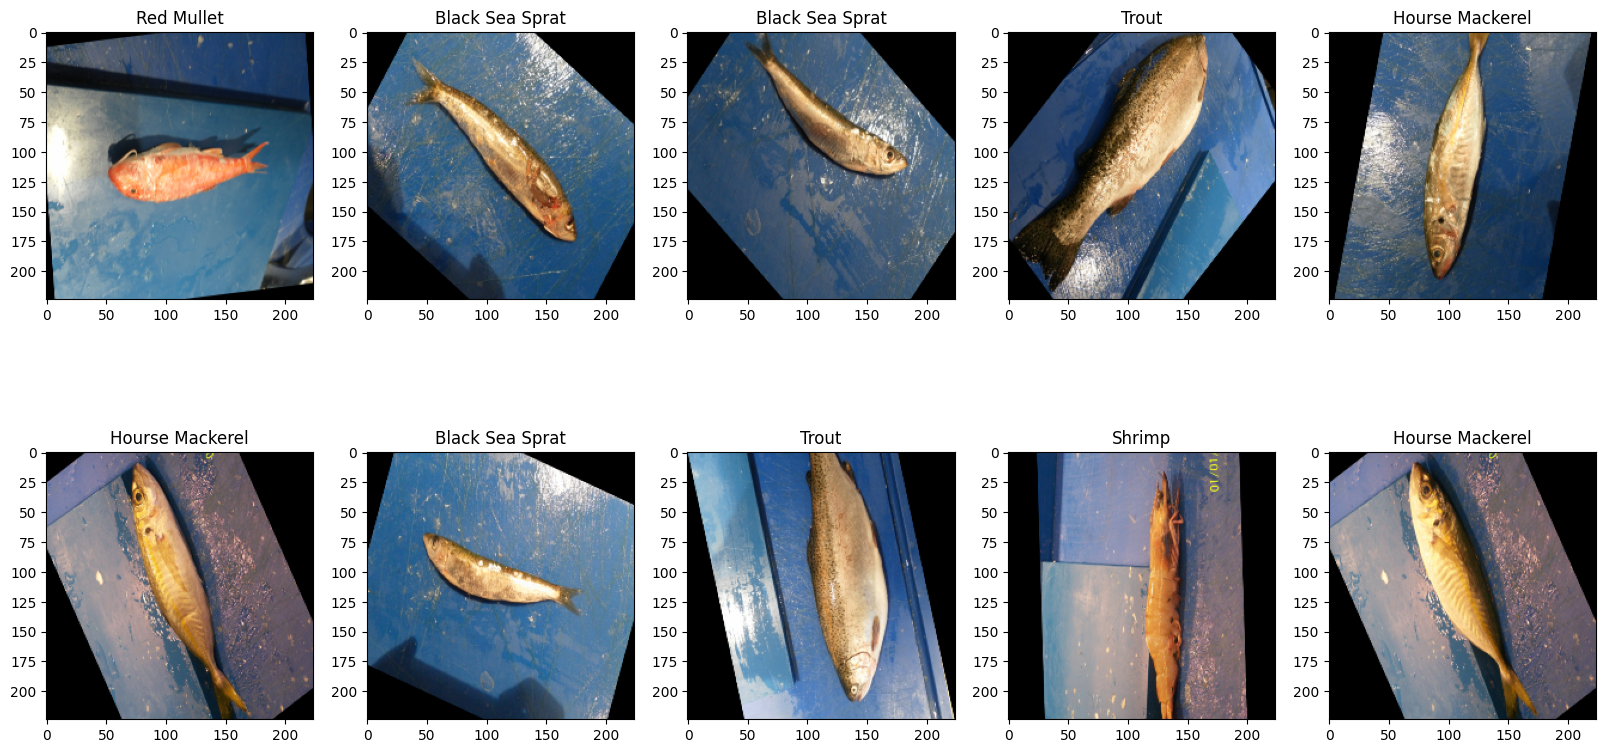

In [80]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [81]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [82]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [83]:
# chuẩn hóa label thành one-hot vector
from keras.utils import np_utils
labels = np_utils.to_categorical(labels, 9)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [84]:
# reshape images
images = np.array(images)
# images = images.reshape(images.shape[0], 150, 150, 3)
images = images.reshape(images.shape[0], 224,224, 3)
images.shape

(9000, 224, 224, 3)

In [85]:
# chuẩn hóa images
# images = images.astype('float32') / 255.0

### Chia dữ liệu Train và Validation

In [86]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((8100, 224, 224, 3), (900, 224, 224, 3), (8100, 9), (900, 9))

In [87]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 900, 1: 900, 2: 900, 3: 900, 4: 900, 5: 900, 6: 900, 7: 900, 8: 900}

### Xây dựng model

In [88]:
h = train_images.shape[1]
w = train_images.shape[2]
c = train_images.shape[3]

In [89]:
model = Sequential()

model.add(Conv2D(kernel_size=4, strides=4, filters=32, padding="same", activation='relu', name="layer_conv1", input_shape=(h,w,c)))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(BatchNormalization())

model.add(Conv2D(kernel_size=2, strides=2, filters=64, padding="same", activation='relu', name="layer_conv2"))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(BatchNormalization())

model.add(Conv2D(kernel_size=2, strides=1, filters=128, padding="same", activation='relu', name="layer_conv3"))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(9, activation="softmax"))

optimizer = Adam()
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_conv1 (Conv2D)        (None, 56, 56, 32)        1568      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 layer_conv2 (Conv2D)        (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                      

In [91]:
history = model.fit(train_images ,train_labels, batch_size=32, epochs=15, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/15
254/254 [==============================] - 21s 76ms/step - loss: 0.8923 - accuracy: 0.6733 - val_loss: 0.1903 - val_accuracy: 0.9667
Epoch 2/15
254/254 [==============================] - 17s 67ms/step - loss: 0.1936 - accuracy: 0.9333 - val_loss: 0.1226 - val_accuracy: 0.9556
Epoch 3/15
254/254 [==============================] - 16s 64ms/step - loss: 0.0889 - accuracy: 0.9699 - val_loss: 0.2883 - val_accuracy: 0.8944
Epoch 4/15
254/254 [==============================] - 16s 63ms/step - loss: 0.0882 - accuracy: 0.9716 - val_loss: 0.0891 - val_accuracy: 0.9744
Epoch 5/15
254/254 [==============================] - 19s 74ms/step - loss: 0.0521 - accuracy: 0.9847 - val_loss: 0.0240 - val_accuracy: 0.9911
Epoch 6/15
254/254 [==============================] - 17s 68ms/step - loss: 0.0518 - accuracy: 0.9840 - val_loss: 0.4139 - val_accuracy: 0.8622
Epoch 7/15
254/254 [==============================] - 18s 69ms/step - loss: 0.0760 - accuracy: 0.9767 - val_loss: 0.0512 - val_accuracy:

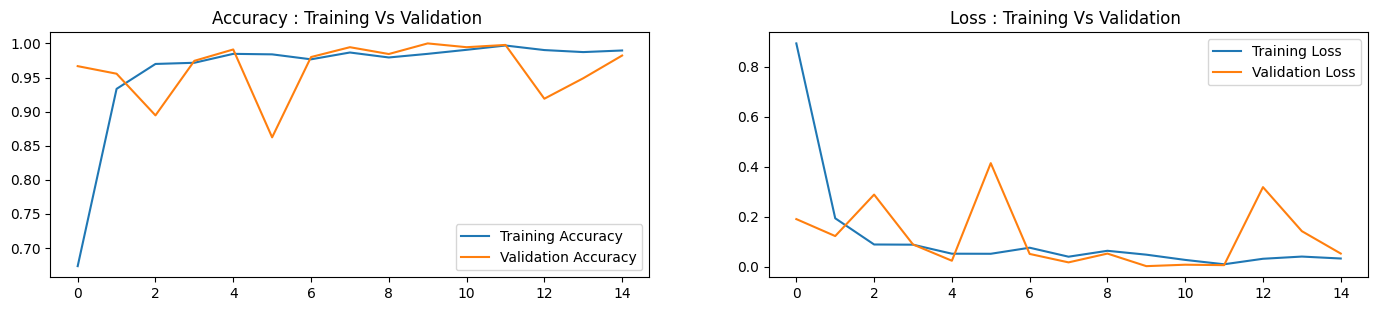

In [92]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(15), accuracy, label='Training Accuracy')
plt.plot(range(15), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show();

In [93]:
# Evaluating the model
score = model.evaluate(val_images, val_labels, verbose=0)
print('val loss:', score[0])
print('Val accuracy:', score[1]*100,"%")

val loss: 0.052665144205093384
Val accuracy: 98.22221994400024 %


Xem test


In [94]:
# đọc tên các lớp :  có 9 loại
DIR_TEST = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset' 
# DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes_test = [i for i in os.listdir(DIR_TEST) if '.' not in i]                     
classes_test

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [143]:
# import os
# import shutil

# original_folder = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset'
# new_folder = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset_new'

# # Duyệt qua tất cả các file trong thư mục gốc và các thư mục con của nó
# for root, dirs, files in os.walk(original_folder):
#     count = 1
#     for filename in files:
#         # Tạo đường dẫn đến file gốc
#         src_path = os.path.join(root, filename)
#         # Tính toán đường dẫn tương đối của thư mục gốc đến file
#         rel_path = os.path.relpath(src_path, original_folder)
#         # Tạo đường dẫn đến file mới
#         dest_path = os.path.join(new_folder, rel_path)
#         # Tạo thư mục mới nếu chưa tồn tại
#         dest_folder = os.path.dirname(dest_path)
#         if not os.path.exists(dest_folder):
#             os.makedirs(dest_folder)
#         # Đổi tên tệp tin mới
#         file_name, file_ext = os.path.splitext(filename)
#         new_file_name = str(count).zfill(5) + '.png'
#         count += 1
#         dest_path = os.path.join(dest_folder, new_file_name)
#         # Copy file gốc sang thư mục mới với tên mới
#         shutil.copy(src_path, dest_path)


In [157]:
path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset_new\\Gilt Head Bream\\00003.png'
img = cv2.imread(path)
height, width, channels = img.shape
print('Chiều cao:', height)
print('Chiều rộng:', width)
print('Số kênh màu:', channels)

path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset_new\\Black Sea Sprat\\00001.png'
img = cv2.imread(path)
height, width, channels = img.shape
print('Chiều cao:', height)
print('Chiều rộng:', width)
print('Số kênh màu:', channels)

Chiều cao: 2128
Chiều rộng: 2832
Số kênh màu: 3
Chiều cao: 768
Chiều rộng: 1024
Số kênh màu: 3


In [175]:
data_test = []
# path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset_new"
path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset_new'
folders_test = os.listdir(path)
for folder in folders_test:
    folder_path = os.path.join(path, folder)
    file_names =  os.listdir(folder_path)
    for i in range(1, len(file_names)+1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        data_test.append([img, folder])


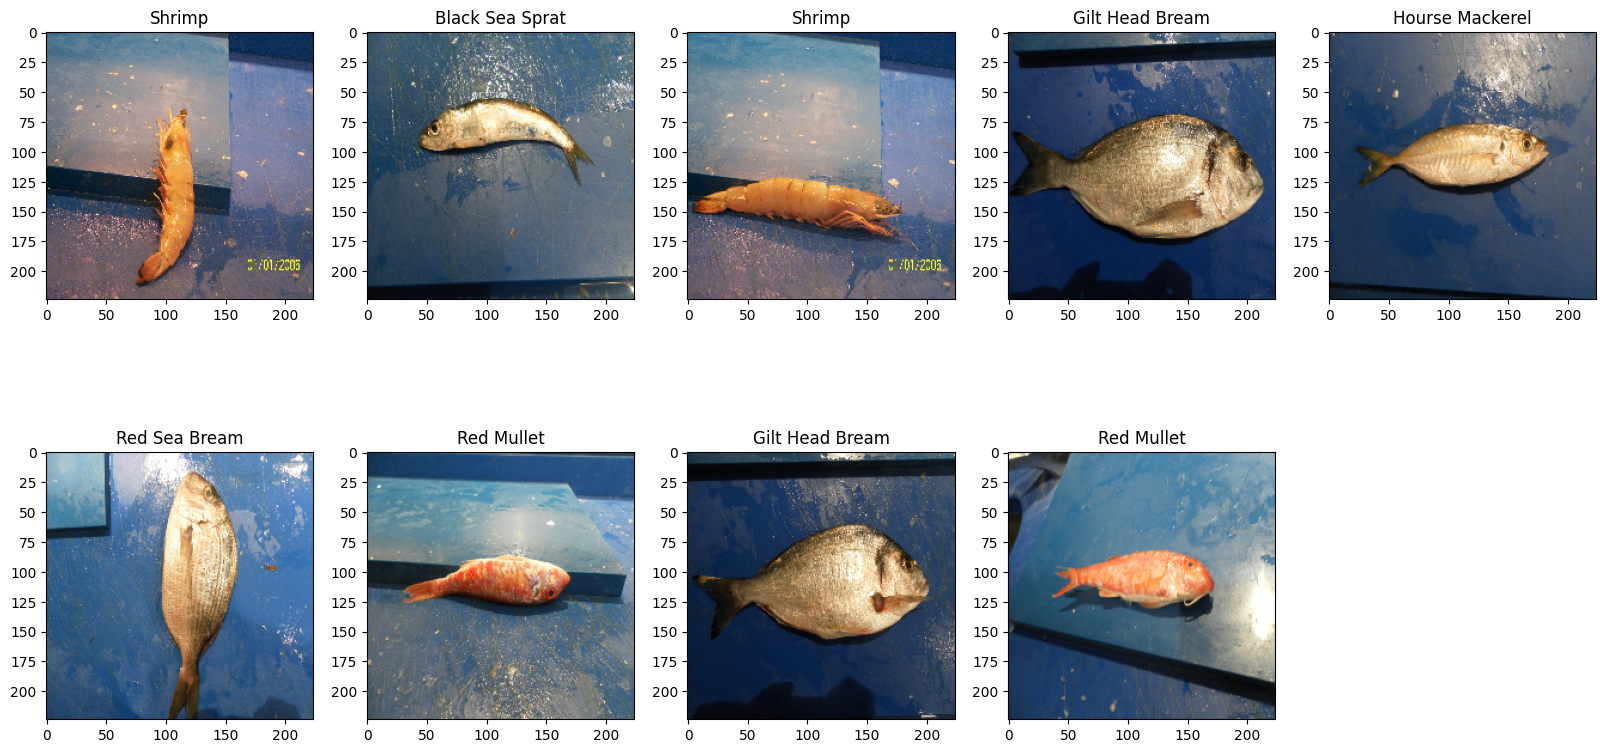

In [176]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 429)
    plt.imshow(data_test[j+i][0])
    plt.title(data_test[j+i][1])

In [177]:
# tạo image và label từ data
images_test = []
labels_test = []
for image, label in data_test:
    images_test.append(image)
    labels_test.append(label)

In [179]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_test = le.fit_transform(labels_test)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [180]:
# chuẩn hóa label thành one-hot vector
from keras.utils import np_utils
labels_test = np_utils.to_categorical(labels_test, 9)
labels_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [181]:
# reshape images
images_test = np.array(images_test)
# images = images.reshape(images.shape[0], 150, 150, 3)
images_test = images_test.reshape(images_test.shape[0], 224,224, 3)
images_test.shape

(430, 224, 224, 3)

In [182]:
images_test.shape, labels_test.shape

((430, 224, 224, 3), (430, 9))

In [ ]:
hhe

In [ ]:
def create_cnn(learning_rate, num_dense_layers, num_dense_nodes, activation, dropout_rate):
    model = Sequential()

    model.add(Conv2D(kernel_size=4, strides=4, filters=32, padding="same", activation=activation, name="layer_conv1"))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(BatchNormalization())

    model.add(Conv2D(kernel_size=2, strides=2, filters=64, padding="same", activation=activation, name="layer_conv2"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(kernel_size=2, strides=1, filters=128, padding="same", activation=activation, name="layer_conv3"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten())

    for i in range(num_dense_layers):
        name = f"layer_dense_{i+1}"
        model.add(Dense(num_dense_nodes, activation=activation, name=name))
        model.add()
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(9, activation="softmax"))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# xác định các hyperparameter
dim_learning_rate = Real(low=1e-6, high=1e-2, prior="log-uniform", name="learning_rate")
dim_num_dense_layers = Integer(low=1, high=5, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=5, high=512, name="num_dense_nodes")
dim_activation = Categorical(categories=["relu", "sigmoid"], name="activation")
dim_dropout_rate = Real(low=0.2, high=0.5, prior="log-uniform", name="dropout_rate")

In [ ]:
param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
    dim_dropout_rate
]

In [ ]:
path_best_model = "cnn_model.h5"
best_accuracy = 0.0

In [ ]:
@use_named_args(param_grid)
def objective(learning_rate, num_dense_layers, num_dense_nodes,activation, dropout_rate):
    print("learning rate: {0:.1e}".format(learning_rate))
    print("num_dense_layers:", num_dense_layers)
    print("num_dense_nodes:", num_dense_nodes)
    print("activation:", activation)
    print()

    model = create_cnn(learning_rate=learning_rate,
                          num_dense_layers=num_dense_layers,
                            num_dense_nodes=num_dense_nodes,
                            activation=activation, dropout_rate=dropout_rate)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)
    history = model.fit(x=train_images,y=train_labels,epochs=10,batch_size=64,validation_split=0.1,callbacks=[learning_rate_reduction])

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy
    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    del model

    return -accuracy

##### Các hyperparameter mặc định

In [ ]:
# default_parameters = [1e-5, 1, 16, "relu", 0.2]
default_parameters = [1e-5, 1, 16, "relu", 0.2]
objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/10
114/114 [==============================] - 86s 748ms/step - loss: 2.1897 - accuracy: 0.1278 - val_loss: 2.1760 - val_accuracy: 0.1938 - lr: 1.0000e-05
Epoch 2/10
114/114 [==============================] - 94s 827ms/step - loss: 2.1628 - accuracy: 0.1635 - val_loss: 2.1405 - val_accuracy: 0.1667 - lr: 1.0000e-05
Epoch 3/10
114/114 [==============================] - 98s 863ms/step - loss: 2.1194 - accuracy: 0.1933 - val_loss: 2.0889 - val_accuracy: 0.1840 - lr: 1.0000e-05
Epoch 4/10
114/114 [==============================] - 107s 936ms/step - loss: 2.0677 - accuracy: 0.2289 - val_loss: 2.0230 - val_accuracy: 0.2494 - lr: 1.0000e-05
Epoch 5/10
114/114 [==============================] - 113s 994ms/step - loss: 2.0038 - accuracy: 0.2646 - val_loss: 1.9510 - val_accuracy: 0.3272 - lr: 1.0000e-05
Epoch 6/10
114/114 [==============================] - 116s 1s/step - loss: 1.9350 - accuracy: 0.3064 - val_

-0.480246901512146

In [ ]:
gp_ = gp_minimize(func=objective,
                    dimensions=param_grid,
                    x0 = default_parameters,
                    acq_func="EI",
                    n_calls=30,
                    random_state=0)

##### Best model

In [ ]:
"Best score=%.4f" % gp_.fun

In [ ]:
print("""Best parameters:
=========================
- learning_rate=%.6f
- num_dense_layers=%d
- num_dense_nodes=%d
- activation=%s""" % (gp_.x[0], gp_.x[1], gp_.x[2], gp_.x[3]))

In [ ]:
plot_convergence(gp_)

In [ ]:
dim_names = ["learning_rate", "num_dense_layers", "num_dense_nodes", "activation"]

In [ ]:
plot_objective(result=gp_, dimensions=dim_names)
plt.show()

In [ ]:
plot_evaluations(result=gp_, dimensions=dim_names)
plt.show()

##### Evaluate the model

In [ ]:
model = load_model(path_best_model)

In [ ]:
result = model.evaluate(x=val_images,y=val_labels)

29/29 [==============================] - 2s 64ms/step - loss: 1.6210 - accuracy: 0.4889


In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 1.621006727218628
accuracy 0.4888888895511627


In [ ]:
y_pred = model.predict(x=val_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(val_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

29/29 [==============================] - 3s 118ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

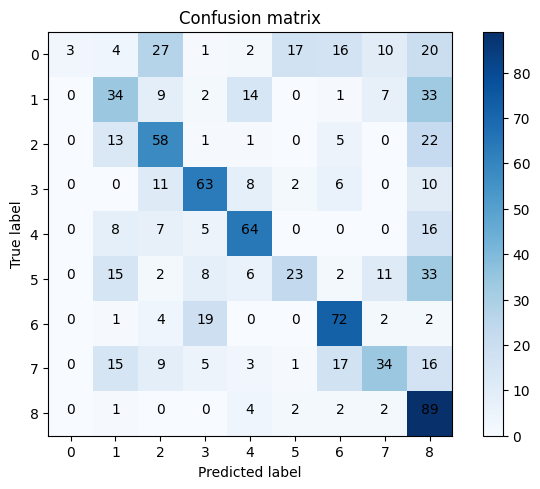

In [ ]:
classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# tính accuracy, recall, precision
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred_classes)
recall = recall_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")
precision = precision_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")

print("Accuracy: {0:.2%}, Recall: {1:.2%}, Precision: {2:.2%}".format(accuracy, recall, precision))

Accuracy: 48.89%, Recall: 48.89%, Precision: 56.16%
